<a href="https://colab.research.google.com/github/rachocr/CCADMACL_EXERCISES_COM222ML/blob/main/Exercise6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 6

Netflix is the world's largest online streaming service provider, with over 220 million subscribers. It is crucial that they effectively cluster the shows that are hosted on their platform in order to enhance the user experience, thereby preventing subscribers from ending their subscription.

We will be able to understand the shows that are similar to and different from one another by creating clusters, which may be leveraged to offer the consumers personalized show suggestions depending on their preferences.

## Instructions

1. Your task is to group the Netflix shows into certain clusters such that the shows within a cluster are similar to each other and the shows in different clusters are dissimilar to each other. Use Principal Component Analysis and any Clustering Algorithm.

2. After creating the clusters, profile each cluster that you have created.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("https://github.com/robitussin/CCADMACL_EXERCISES/blob/353cd84703a9e313ee7ecf37fb97a067aa81ddbc/netflix.csv?raw=true")

In [3]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [4]:
df.shape

(7787, 12)

1. Apply dimensionality reduction using Principal Component Analysis
- Use the necessary number of principal components

In [5]:
df.fillna('', inplace=True)

In [6]:
def extract_duration(duration):
    if 'min' in duration:
        return int(duration.split()[0])
    elif 'Season' in duration:
        return int(duration.split()[0]) * 60  # Assuming 1 season ~ 60 minutes for simplicity
    return 0
df['Duration_Minutes'] = df['duration'].apply(extract_duration)

In [7]:
# Add family size proxy by counting cast members
def count_cast(cast):
    return len(cast.split(',')) if cast else 0
df['Family_Size'] = df['cast'].apply(count_cast)


In [8]:
# Add parenthood status proxy (1 if type is 'TV Show', assuming more family-oriented)
df['Parenthood_Status'] = df['type'].apply(lambda x: 1 if x == 'TV Show' else 0)

In [9]:
# Simplify country into binary (1 if not USA, 0 otherwise)
df['International'] = df['country'].apply(lambda x: 0 if 'United States' in x else 1)


In [10]:
# Select relevant features for clustering
features = ['Family_Size', 'Parenthood_Status', 'Duration_Minutes', 'International']

In [11]:
# Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[features])

In [12]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

2. Create a scree plot for each principal component

In [13]:
explained_variance = pca.explained_variance_ratio_

PC1_explainedvariance = explained_variance[0]
print("Explained variance of PC1", PC1_explainedvariance)

PC2_explainedvariance = explained_variance[1]
print("Explained variance of PC2", PC2_explainedvariance)

Explained variance of PC1 0.3054278146542653
Explained variance of PC2 0.27124727410312965


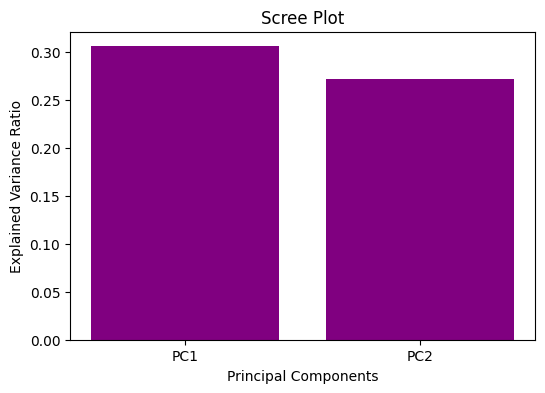

In [14]:
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(6, 4))
plt.bar(['PC1', 'PC2'], explained_variance, color='purple')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.show()


*3*. Use any clustering algorithm to create clusters

In [15]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=42)
clusters = kmeans.fit_predict(df_pca)


In [16]:
df['Cluster'] = clusters

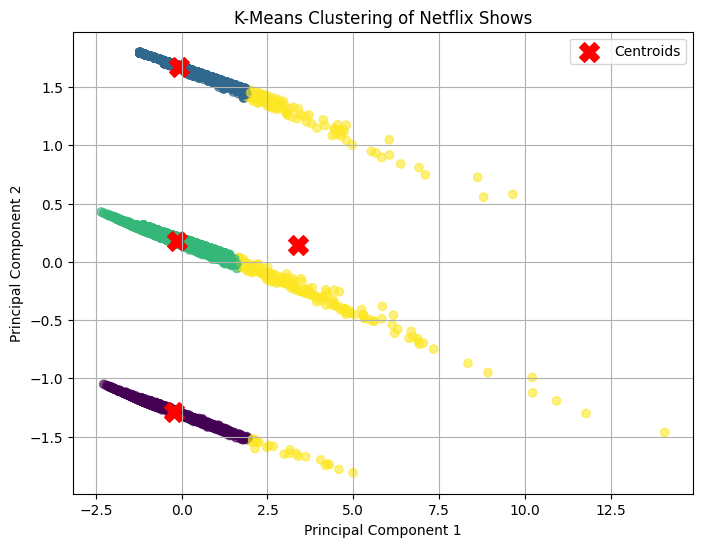

In [17]:
plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', marker='X', label='Centroids')
plt.title('K-Means Clustering of Netflix Shows')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
cluster_profiles = df.groupby('Cluster')[features].mean()
print("Cluster Profiles:\n", cluster_profiles)


Cluster Profiles:
          Family_Size  Parenthood_Status  Duration_Minutes  International
Cluster                                                                 
0           7.044020           0.000000         91.968439       0.000000
1           6.834262           1.000000         76.420613       1.000000
2           6.703056           0.183611        101.798333       0.816389
3          14.717201           0.912536        271.443149       0.335277


4. Profile each cluster that you have generated based on your experiments

In [19]:
for cluster, profile in cluster_profiles.iterrows():
    print(f"\nCluster {cluster}:")
    print(f"  Average Family Size: {profile['Family_Size']:.2f}")
    print(f"  Parenthood Status (Percentage Parents): {profile['Parenthood_Status'] * 100:.2f}%")
    print(f"  Average Duration (Minutes): {profile['Duration_Minutes']:.2f}")
    print(f"  International Content (Percentage): {profile['International'] * 100:.2f}%")



Cluster 0:
  Average Family Size: 7.04
  Parenthood Status (Percentage Parents): 0.00%
  Average Duration (Minutes): 91.97
  International Content (Percentage): 0.00%

Cluster 1:
  Average Family Size: 6.83
  Parenthood Status (Percentage Parents): 100.00%
  Average Duration (Minutes): 76.42
  International Content (Percentage): 100.00%

Cluster 2:
  Average Family Size: 6.70
  Parenthood Status (Percentage Parents): 18.36%
  Average Duration (Minutes): 101.80
  International Content (Percentage): 81.64%

Cluster 3:
  Average Family Size: 14.72
  Parenthood Status (Percentage Parents): 91.25%
  Average Duration (Minutes): 271.44
  International Content (Percentage): 33.53%
